# Home Owner Loan Corporation (HOLC)

Minnesota Department of Transport (MnDoT)

Output Coordinate Reference System: UTM 15N - EPSG:26915

Source: https://gisdata.mn.gov/dataset/us-mn-state-metc-plan-historic-holc-appraisal

Metadata: https://resources.gisdata.mn.gov/pub/gdrs/data/pub/us_mn_state_metc/plan_historic_holc_appraisal/metadata/metadata.html

In [1]:
### Import Libraries

# File manipulation

import os # For working with Operating System
from sys import platform # Diagnose operating system
import shutil # For deleting folders
import urllib # For accessing websites
import zipfile # For extracting from Zipfiles
from io import BytesIO # For reading bytes objects

# Analysis

import numpy as np # For working with Arrays
import pandas as pd # Data Manipulation
import geopandas as gpd # Spatial Data Manipulation

# Visualization

import matplotlib.pyplot as plt # Basic Plotting
import seaborn as sns # Statistical Plotting
import contextily # Base Map Visualization

In [2]:
### Definitions

cwd = os.getcwd() # Current Working Directory

def extract_zip_from_url(url=None):
    '''Extract a zipfile from the internet and unpack it in to it's own folder within working directory.
    Takes a single url (string).'''
    
    if type(url) == str: # Single url
        # Create folder name for file
        folder_name = url.split('/')[-1][:-4]
        # Make folder for files
        path = os.path.join(cwd, folder_name)
        if folder_name not in os.listdir():
            os.mkdir(path)
        # Unload zip into the new folder
        response = urllib.request.urlopen(url) # Get a response
        zip_folder = zipfile.ZipFile(BytesIO(response.read())) # Read Response
        zip_folder.extractall(path=path) # Extract files
        zip_folder.close() # Close zip object
    else:
        print('Error Extracting: Invalid Input')

In [3]:
### Load, Clip, & Plot

if os.path.exists('Data/holc.geojson'): # If already in directory
    
    holc = gpd.read_file('Data/holc.geojson')
    
    
else: # Download and clip
    
    ## AADT for all of Minnesota - Downloaded from MN GeospatialCommons gisdata.mn.gov  (~ 5mb)
    
    print('Downloading HOLC from GeoSpatialCommons (~5mb)')

    url = 'https://resources.gisdata.mn.gov/pub/gdrs/data/pub/us_mn_state_metc/plan_historic_holc_appraisal/shp_plan_historic_holc_appraisal.zip'
    extract_zip_from_url(url)
    ## Load and clip
    
    

    # Get path

    folder = url.split('/')[-1][:-4] # Get folder name (last part of address minus .zip)
    filename = 'HistoricHOLCNeighborhoodAppraisal.shp'
    path = folder + '/' + filename

    holc_mn = gpd.read_file(path) # Read data to geodataframe
    
    # Clip
    
    extent = gpd.read_file('Data/study_extent.geojson') # Load Extent
    
    holc_mn = holc_mn.to_crs('EPSG:26915') # Get into same CRS
    
    holc = gpd.clip(holc_mn, extent) # Clip
 

In [5]:
holc.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 11561 entries, 0 to 11560
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   HSG_SCALE   11561 non-null  object  
 1   Shape_Leng  11561 non-null  float64 
 2   Shape_Area  11561 non-null  float64 
 3   geometry    11561 non-null  geometry
dtypes: float64(2), geometry(1), object(1)
memory usage: 361.4+ KB


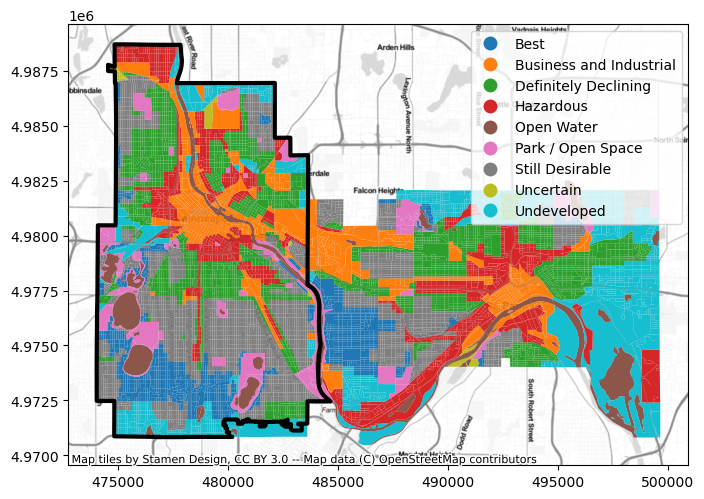

In [9]:
# Spatially Show Data

# Load Minneapolis Boundary

mpls = gpd.read_file('Data/mpls_boundary.geojson')

f, ax = plt.subplots(1,1,figsize = (8,8))

holc.plot(column = 'HSG_SCALE', legend = True, ax = ax)

mpls.plot(ax = ax,
         edgecolor='black', facecolor='none',
         linewidth=3,
         zorder = 2,
         legend = True)

contextily.add_basemap(ax = ax, 
                       crs = mpls.crs, 
                       source = contextily.providers.Stamen.TonerLite
                      )

# Reclassify

In [7]:
# Classes - https://ncrc.org/holc/
# https://journals.sagepub.com/doi/10.1177/23998083221133112
# https://ncrc.org/wp-content/uploads/dlm_uploads/2018/02/NCRC-Research-HOLC-10.pdf

classes = np.unique(holc.HSG_SCALE)

['Best' 'Business and Industrial' 'Definitely Declining' 'Hazardous'
 'Open Water' 'Park / Open Space' 'Still Desirable' 'Uncertain'
 'Undeveloped']



- Best is the best, they get loans = 1
- hazardous is bad (no fed loans/redlining) = -1 
- business and industrial are bad but not residential? = 0
- As are parks (tho these are good), and open water (also good) = 0
- Definitely Declining is "in transition", sort of redlining - maybe gentrification, developers would get loans = 1
- Still Desirable is "stable" = 2, they get loans = 1
- Uncertain is... uncertain, they but probably get loans for gentrification/development = 1
- Undeveloped is good, development ensues, loans for sure = 1

Could maybe leave it categorical. Definitely need demographics!

In [11]:
# Make reclassify map <- this probably isn't right, but will need to figure out at some point

classes_map = {'Best':1,
               'Business and Industrial':0,
               'Definitely Declining':1,
               'Hazardous':-1,
               'Open Water':0,
               'Park / Open Space':0,
               'Still Desirable':1,
               'Uncertain':1,
               'Undeveloped':1
              }

In [13]:
# Add to dataframe

holc['Reclassify'] = holc.HSG_SCALE.apply(lambda x: classes_map[x])

In [14]:
# Save aadt as geojson

holc.to_file(r'Data/holc.geojson', driver='GeoJSON') # Save geojson